In [26]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 4. Feature Importances

In [2]:
# Loading libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [3]:
# Loading cleaned data
df_features_combined = pd.read_csv('data/df_features_combined.csv')
df_features_combined.shape

(19387, 16)

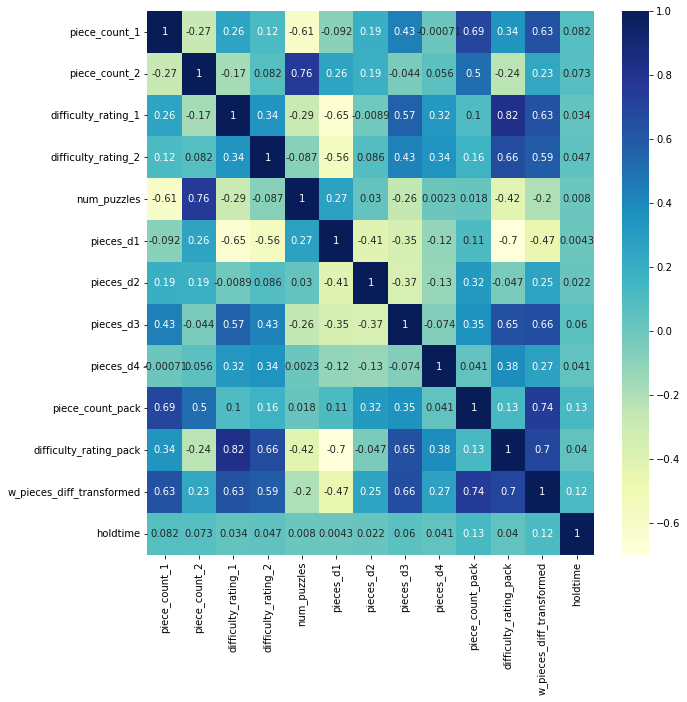

In [4]:
# plotting correlation heatmap
plt.figure(figsize=(10,10))
dataplot = sns.heatmap(df_features_combined.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [5]:
# random split into train and validation
train, test = train_test_split(df_features_combined, test_size = 0.25, random_state=1)

In [6]:
x_train = train.drop(['holdtime', 'pack_name'], axis=1)
y_train = train['holdtime']

In [7]:
x_test = test.drop(['holdtime', 'pack_name'], axis = 1)
y_test = test['holdtime']

### 4.1 Benchmark Model

In [8]:
# First just try average hold time by member
train_holdtime_mean = y_train.mean()

pred1 = np.empty(len(y_test)) 
pred1.fill(train_holdtime_mean)

mean_absolute_error(y_test, pred1)

12.62234436965736

### 4.2 Linear Regression

In [9]:
# dummy variable - hopefully x_test doesnt bring any surprises
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_train.shape, x_test.shape

((14540, 32), (4847, 32))

In [10]:
# simple linear regression
model_lr = LinearRegression(normalize=True)
model_lr.fit(x_train, y_train)  #fit the model
pred2 = model_lr.predict(x_test) #make prediction on test set
mean_absolute_error(y_test, pred2) #calculate mae

12.422053647064944

In [11]:
coefficients = pd.concat([pd.DataFrame(x_train.columns,columns=['columns']),
                          pd.DataFrame(np.transpose(model_lr.coef_),columns=['coefficients'])], axis = 1)
coefficients.sort_values(by = 'coefficients').head(15)

,columns,coefficients
0,piece_count_1,-5.427657e+11
1,piece_count_2,-5.427657e+11
29,brand_2_Stave,-4.353840e+00
16,brand_1_Nautilus,-2.782904e+00
18,brand_1_Other-Laser-cut,-2.748214e+00
27,brand_2_Other-Hand-cut,-1.944098e+00
13,brand_1_DaVici,-1.835529e+00
4,num_puzzles,-1.622190e+00
15,brand_1_Liberty,-1.421600e+00
20,brand_1_Wentworth,-1.149477e+00


Cannot say anything about the coefficients right now. Need p-values. Building OLS model to get that.

### 4.3 OLS model

In [ ]:
import statsmodels

In [13]:
from sklearn import datasets, linear_model
import statsmodels.api as sma

In [14]:
X = x_train
y = y_train
X2  = sma.add_constant(X)

In [15]:
est = sma.OLS(y, X2.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               holdtime   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     13.29
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           6.21e-61
Time:                        00:14:09   Log-Likelihood:                -63076.
No. Observations:               14540   AIC:                         1.262e+05
Df Residuals:                   14511   BIC:                         1.264e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

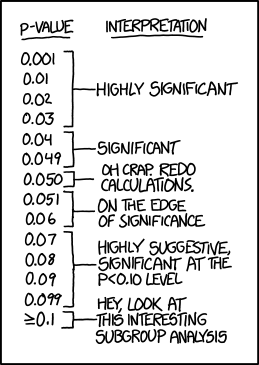

### 4.4 Decision Tree

In [16]:
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = {'max_depth': [3, 5, 7, 9, 11, 15, 17]}
    # decision tree model
    dtree_model = DecisionTreeRegressor()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [17]:
dtree_grid_search(X = x_train, y = y_train, nfolds = 5)

{'max_depth': 3}

In [18]:
model_dt = DecisionTreeRegressor(max_depth = 3,random_state=0)
model_dt.fit(x_train, y_train)  #fit the model
pred3 = model_dt.predict(x_test) #make prediction on test set
mean_absolute_error(y_test, pred3) #calculate mae

12.447865314968272

In [19]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, model_dt.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [20]:
importances.sort_values(by = 'Gini-importance', ascending=False).head(15)

,Gini-importance
piece_count_pack,0.607699
w_pieces_diff_transformed,0.258662
brand_1_Artifact,0.088650
pieces_d3,0.044989
brand_2_Ecru,0.000000
brand_1_Wentworth,0.000000
brand_1_unknown,0.000000
brand_2_Artifact,0.000000
brand_2_DaVici,0.000000
piece_count_1,0.000000


### 4.4 Random Forest

In [21]:
def rf_grid_search(X,y,nfolds):
    param_grid = {'max_depth': [3, 5, 7, 9], 'n_estimators': [50, 70, 100, 150, 200]}
    rf_model = RandomForestRegressor()
    rf_gscv = GridSearchCV(rf_model, param_grid, cv=nfolds)
    rf_gscv.fit(X, y)
    return rf_gscv.best_params_

In [22]:
rf_grid_search(X = x_train, y = y_train, nfolds = 5)

{'max_depth': 3, 'n_estimators': 100}

In [23]:
model_rf = RandomForestRegressor(max_depth = 3,n_estimators=200, random_state=0)
model_rf.fit(x_train, y_train)  #fit the model
pred4 = model_rf.predict(x_test) #make prediction on test set
mean_absolute_error(y_test, pred4) #calculate mae

12.436204414656602

In [24]:
feats_rf = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, model_rf.feature_importances_):
    feats_rf[feature] = importance #add the name/value pair 

importances_rf = pd.DataFrame.from_dict(feats_rf, orient='index').rename(columns={0: 'feature_importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [25]:
importances_rf.sort_values(by='feature_importance', ascending=False).head(15)

,feature_importance
piece_count_pack,0.575958
w_pieces_diff_transformed,0.213131
brand_1_Artifact,0.046877
piece_count_1,0.043080
pieces_d4,0.033324
piece_count_2,0.016813
pieces_d3,0.015915
pieces_d1,0.015663
pieces_d2,0.011825
difficulty_rating_1,0.007307


# Merging all feature importance

### 